# PISCES wavelength calibration

We have PISCES VARIA calibration sets. We will show how to process them to build a new wavelength calibration

In [1]:
import numpy as np
import glob
from astropy.io import fits
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=20)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=20)
plt.rc('image',origin='lower',interpolation='nearest')

import sys
import os

Populating the interactive namespace from numpy and matplotlib


### Import crispy-related stuff

In [2]:
os.chdir('/Users/mrizzo/IFS/crispy/crispy/PISCES/')

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.tools.image import Image
from PISCESparams import Params
par = Params()
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

## Build wavelength calibration files

In [3]:
# We need to run the calibration for the first time
from crispy.tools.wavecal import buildcalibrations
par.gaussian_hires=False # since par.gaussian_hires is False, it will attempt to make high-resolution PSFLets
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
buildcalibrations(par,
                    inspect=False,
                    genwavelengthsol=False, # Compute wavelength at the center of all pixels
                    makehiresPSFlets=False, # this requires very high SNR on the monochromatic frames
                    makePolychrome=True,   # This is needed to use least squares extraction
                    makePSFWidths=True,    # Fit PSF widths from high-res PSFLet models
                    upsample=3,            # upsampling factor of the high-resolution PSFLets
                    nsubarr=4,             # the detector is divided into nsubarr^2 regions for PSFLet averaging
                    apodize=False,          # to match PSFlet spot locations, only use the inner circular part of the 
                                           #detector, hence discarding the corners of the detector where lenslets are 
                                           #distorted
                  ) 

crispy - INFO - Building calibration files, placing results in ..//ReferenceFiles/Calibra_170425/
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det615.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det625.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det635.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det645.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det655.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det665.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det675.0.fits
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - Read d

In [5]:
#par.lamlist = np.arange(615.,720.,10)

from crispy.tools.reduction import calculateWaveList
lam_midpts,lam_endpts = calculateWaveList(par,method='lstsq')
print('Wavelengths at midpoints for lstsq (nm): ',lam_midpts)
print('Wavelengths at endpoints for lstsq (nm): ',lam_endpts)
lam_midpts,lam_endpts = calculateWaveList(par,method='optext')
print('Wavelengths at midpoints for optext (nm): ',lam_midpts)
print('Wavelengths at endpoints for optext (nm): ',lam_endpts)

crispy - INFO - Reduced cube will have 11 wavelength bins
('Wavelengths at midpoints for lstsq (nm): ', array([ 609.9964569 ,  620.11350281,  630.39834414,  640.85376386,
        651.48259108,  662.28770183,  673.27201986,  684.43851739,
        695.79021595,  707.33018716,  719.06155361]))
('Wavelengths at endpoints for lstsq (nm): ', array([ 605.        ,  615.03417758,  625.23477618,  635.60455597,
        646.14632289,  656.86292941,  667.75727532,  678.83230851,
        690.09102575,  701.53647351,  713.17174881,  725.        ]))
crispy - INFO - Reduced cube will have 26 wavelength bins
('Wavelengths at midpoints for optext (nm): ', array([ 607.10887147,  611.34869295,  615.61812376,  619.91737068,
        624.24664194,  628.6061472 ,  632.99609763,  637.41670582,
        641.86818589,  646.35075344,  650.86462556,  655.41002088,
        659.98715953,  664.59626322,  669.23755516,  673.91126015,
        678.61760456,  683.35681631,  688.12912494,  692.9347616 ,
        697.7739590

## Monochromatic updates

In [6]:
from crispy.tools.wavecal import monochromatic_update
from crispy.tools.image import Image
# let's pretend that we got a new file
# inImage = Image(par.codeRoot+"/Inputs/Flat637.fits")
# inLam = 637.
inImage = Image(par.wavecalDir+'det685.0.fits')
inLam=685.

# this adjusts the wavecal
monochromatic_update(par,inImage,inLam,apodize=True)
# but you still have to re-run buildcalibrations each time
from crispy.tools.wavecal import buildcalibrations
par.gaussian_hires=False # since par.gaussian_hires is False, it will attempt to make high-resolution PSFLets
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
buildcalibrations(par,
                    inspect=True,
                    genwavelengthsol=False, # already done before
                    makehiresPSFlets=False, # already done
                    makePolychrome=True, # update the polychrome with the new wavecal!
                    upsample=3,
                    nsubarr=4
                 )




crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - Making copies of wavelength solution from ..//ReferenceFiles/Calibra_170425//lamsol.dat
crispy - INFO - Generating new wavelength solution
crispy - INFO - Initializing transformation coefficients with previous values
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ..//ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - 0.34: x-shift from archival spot positions (pixels)
crispy - INFO - -0.59: y-shift from archival spot positions (pixels)
crispy - INFO - -0.00: rotation from archival spot positions (degrees)
crispy - INFO - Overwriting old wavecal
crispy - INFO - Don't forget to run buildcalibrations again with makePolychrome=True!
crispy - INFO - Building calibration files, placing results in ..//ReferenceFiles/Calibra_170425/
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy -

In [7]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image

cube = reduceIFSMap(par,par.codeRoot+"/Inputs/Flat637.fits",method='optext',smoothbad=True) # smoothbad=True is the default
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/Flat637.fits",method='lstsq')
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq')
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='optext')
cube = reduceIFSMap(par,par.wavecalDir+"det655.0.fits",method='lstsq')

# reduce an array directly instead of a FITS file
cube_array = Image(filename= par.wavecalDir+"det655.0.fits").data

# now cube_array is a simple 2D array. Function is the same, but the argument is changed from a string to an array.
# You can also specify name="my_name" in the arguments, and it will output a file called "my_name_red_optext.fits"
# If name is unspecified, it creates a file with the date and time as a base, result of the function
# time.strftime("%Y%m%d-%H%M%S")
cube = reduceIFSMap(par,cube_array,method='lstsq')


crispy - INFO - Read data from HDU 1 of ..//Inputs/Flat637.fits
crispy - INFO - Reduced cube will have 26 wavelength bins
crispy - INFO - Elapsed time: 1.524932s
crispy - INFO - Read data from HDU 1 of ..//Inputs/Flat637.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/Flat637_red_lstsq_resid.fits
crispy - INFO - Writing data to ..//SimResults/Flat637_red_lstsq_model.fits
crispy - INFO - Elapsed time: 4.164805s
crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Writing data to ..//SimResults/BB_red_lstsq_model.fits
crispy - INFO - Elapsed time: 4.141197s
crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits
crispy - INFO - Reduced cube will have 26 wavelength bins
crispy - INFO - Elapsed time: 1.549576s
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_1

# Construct lenslet bad pixel/flatfield from broadband reduced cube

The following only works if the reduced cube is first done WITHOUT already correcting for lenslet flatfield. To do this, run the but only AFTER running deleting the keywords in the parameters class:

In [3]:
from crispy.IFS import reduceIFSMap

if hasattr(par,'lenslet_flat'): del par.lenslet_flat
if hasattr(par,'lenslet_mask'): del par.lenslet_mask
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq',smoothbad=False)
# cubeOpt = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='optext',smoothbad=False)


crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Writing data to ..//SimResults/BB_red_lstsq_model.fits
crispy - INFO - Elapsed time: 4.119495s


crispy - INFO - Read data from HDU 1 of ..//SimResults/BB_red_lstsq.fits
crispy - INFO - Read inverse variance from HDU 2 of ..//SimResults/BB_red_lstsq.fits
('Mean, sig in central 20 lenslets:', 4521.3896, 244.69797)
crispy - INFO - Writing data to ..//SimResults/lenslet_flat.fits
crispy - INFO - Writing data to ..//SimResults/lenslet_mask.fits


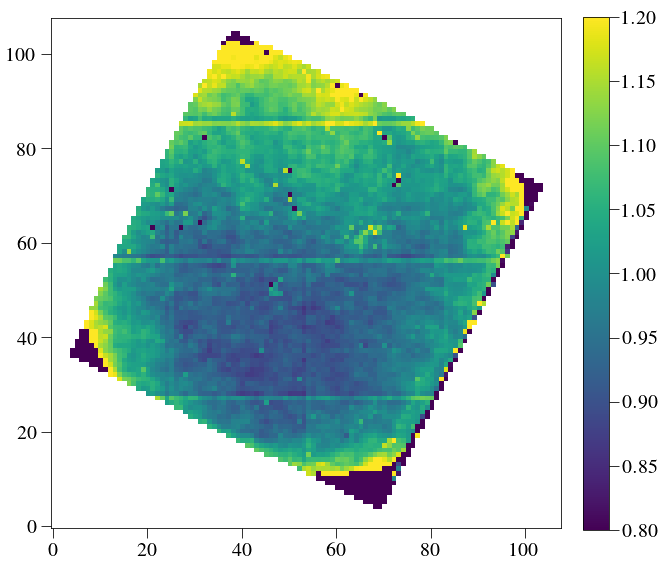

In [7]:
from crispy.tools.imgtools import gen_lenslet_flat
BBcube = Image(par.exportDir+"/BB_red_lstsq.fits")
lenslet_flat,lenslet_mask = gen_lenslet_flat(BBcube)
Image(data = lenslet_flat).write(par.exportDir+"/lenslet_flat.fits",clobber=True)
Image(data = lenslet_mask).write(par.exportDir+"/lenslet_mask.fits",clobber=True)
plt.figure(figsize=(10,10))
plt.imshow(lenslet_flat*lenslet_mask, cmap='viridis',vmin=0.8,vmax=1.2)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


In [ ]:
psflets = Image(par.wavecalDir+"/hires_psflets_lam605.fits").data
fig, axarr = plt.subplots(4,4,figsize=(12,12))
for i in range(psflets.shape[0]):
    for j in range(psflets.shape[1]):
        axarr[i,j].imshow(psflets[i,j],vmin=0.0)
        axarr[i,j].axis('off')
plt.subplots_adjust(wspace=0.0,hspace=0.05)
plt.savefig(par.wavecalDir+"psflets.png")        
plt.show()


### Scratch work with the PSF width determination

In [ ]:
import re
# par.wavecalDir = '../ReferenceFiles/wavecalR50_660/'
hires_list = np.sort(glob.glob(par.wavecalDir + '/hires_psflets_lam???.fits'))
hires_arrs = [fits.open(filename)[0].data for filename in hires_list]
lam_hires = [int(re.sub('.*lam', '', re.sub('.fits', '', filename)))
             for filename in hires_list]
psflet_res = 3 # Oversampling of high-resolution PSFlet images


In [ ]:
print lam_hires
print hires_arrs[0].shape
print par.wavecalDir

In [ ]:
shape = hires_arrs[0].shape
sigarr = np.zeros((len(hires_list), shape[0], shape[1]))
_x = np.arange(shape[2])/float(psflet_res)
_x -= _x[_x.shape[0]//2]

for i in range(sigarr.shape[0]):
    for j in range(sigarr.shape[1]):
        for k in range(sigarr.shape[2]):                
# for i in range(1):
#     for j in range(1):
#         for k in range(1):                
            row = np.sum(hires_arrs[i][j, k, :, shape[3]//2-1:shape[3]//2+1],axis=1) 
#             row = np.sum(row.reshape((row.shape[0]//3,3)),axis=1)/3.
#             xrow = np.sum(_x.reshape((_x.shape[0]//3,3)),axis=1)/3.
            sigarr[i, j, k] = np.sum(row*_x**2)
            sigarr[i, j, k] /= np.sum(row)

    sigarr[i] = np.sqrt(sigarr[i])


In [ ]:
from crispy.tools.detutils import frebin
#row = np.sum(hires_arrs[i][j, k, :, shape[3]//2-1:shape[3]//2+1],axis=1)
#print _x.shape
#sh= np.sum(row.reshape((row.shape[0]//3,3)),axis=1)/3.
#xsh = np.sum(_x.reshape((_x.shape[0]//3,3)),axis=1)/3.
#print sh.shape
# plt.plot(xrow,row)
plt.plot(_x,row)
plt.plot(_x,np.exp(-_x**2/2./sigarr[i, j, k]**2)/np.sqrt(sigarr[i, j, k])/np.sqrt(2.*np.pi)/0.6)

In [ ]:
print sigarr[i, j, k]

In [ ]:
from crispy.tools.locate_psflets import PSFLets
lam = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]
psftool = PSFLets()
lam1 = min(lam)
lam2 = max(lam)
psftool.genpixsol(par,lam, allcoef, order=3,lam1=lam1/1.02, lam2=lam2*1.02)


In [ ]:
from scipy import ndimage,interpolate
from scipy import interpolate
mean_x = psftool.xindx[:, :, psftool.xindx.shape[-1]//2]
mean_y = psftool.yindx[:, :, psftool.yindx.shape[-1]//2]

longsigarr = np.zeros((len(lam_hires), mean_x.shape[0], mean_x.shape[1]))

ix = mean_x*hires_arrs[0].shape[1]/par.npix - 0.5
iy = mean_y*hires_arrs[0].shape[0]/par.npix - 0.5

for i in range(sigarr.shape[0]):
    longsigarr[i] = ndimage.map_coordinates(sigarr[i], [iy, ix], order=3, mode='nearest')
fullsigarr = np.ones((psftool.xindx.shape))
for i in range(mean_x.shape[0]):
    for j in range(mean_x.shape[1]):
        if psftool.good[i,j]:
            fit = interpolate.interp1d(np.asarray(lam_hires), longsigarr[:, i, j],
                                       bounds_error=False, fill_value='extrapolate')
            fullsigarr[i, j] = fit(psftool.lam_indx[i, j])

In [ ]:
plt.imshow(fullsigarr[:,:,10])
plt.colorbar()


In [10]:
from crispy.tools.reduction import _add_row
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits' % (par.R))
psflets = polychromeR[0].data
print psflets.shape
psflets2 = _add_row(psflets,n=1)
print psflets2.shape
print psflets2[-1:].shape

(11, 1032, 1056)
(12, 1032, 1056)
(1, 1032, 1056)


If you are satisfied with the flatfielding and masking, move the two fits files into the wavecal directory and reduce things with the two class attributes defined. When you reload the parameter file, the two attributes automatically get reset.